Script for analyzing MCell molecule location data for calcium diffusion

Last updated: 11/29/21

In [19]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats
from math import pi

In [28]:
def ca_snare_finder(mcell_viz_dir, timepoint):
    '''
    Calculates average and standard deviation of concentration of calcium across all seeds
    in a box around the SNARE complexes at a given time for MCell simulation.

    :param mcell_dir: MCell ASCII data location
    :param timepoint: which iteration/time point to plot
    :param plot: if output should be plotted

    :return: concentration of Ca in the SNARE at the given timepoint
    '''   
    
    # SNARE box dimensions (using refrac box dimensions)
    delta_x = 0.1   # SNARE BOX X LEN (um)
    delta_y = 0.1   # SNARE BOX Y LEN (um)
    delta_z = 0.1    # SNARE BOX X LEN (um)

    # SNARE BOX LOCATION
    # for a giant box snare complex 
    z_s = -.24550 # using refrac box location
    snare_locs = [(0, 0, z_s)] # for only one giant SNARE (x, y, z)

    n_ca_all_seeds = []

    # for each seed, find the concentration of Ca2+ in the snare box at timepoint
    for seed in sorted(os.listdir(mcell_viz_dir)):

        # data file location
        seed_data_dir = os.path.join(mcell_viz_dir, seed, 'Scene.ascii.{}.dat'.format(timepoint))

        # create dataframe
        loc_data = pd.read_csv(seed_data_dir, delim_whitespace=True, header=None,
                           names=['type', 'id', 'x', 'y', 'z', 'norm_x', 'norm_y', 'norm_z'])

        # select only calcium
        loc_data = loc_data[loc_data['type'] == 'ca']

        # initialize number of calcium in SNARE rxn zone
        snare_ca_tot = 0        

        # ONLY 1 SNARE TO START (big snare box)
        for x_s, y_s, z_s in snare_locs:

            # Ugly method (TODO: make nicer)
            # get calcium location (x,y,z)
            for ca_x, ca_y, ca_z in zip(loc_data['x'], loc_data['y'], loc_data['z']):
                # check z direction
                if (ca_z >= z_s - (delta_z / 2)) & (ca_z <= z_s + (delta_z / 2)):

                    # check x direction
                    if (ca_x >= x_s - (delta_x / 2)) & (ca_x <= x_s + (delta_x / 2)):

                        # check y direction
                        if (ca_y >= y_s - (delta_y / 2)) & (ca_y <= y_s +  (delta_y / 2)):
                            snare_ca_tot += 1
            
        # append seed conc to all seeds
        n_ca_all_seeds.append(snare_ca_tot)

    return np.mean(n_ca_all_seeds), np.std(n_ca_all_seeds)

In [29]:
# plot for multiple time points
mcell_dir = "/Users/margotwagner/ucsd/research/DiffusionModel/" \
            "rect_zeroflux_nocalbpmca_files/mcell/output_data/viz_data_ascii"

# get time points
timepts = [scene.split('.')[2] for scene in os.listdir(os.path.join(mcell_dir, 'seed_00001'))]
timepts.sort()

#sample points
sampled_timepts = [timepts[i] for i in range(len(timepts)) if i%1==0]
print(sampled_timepts)

['0000', '0005', '0010', '0015', '0020', '0025', '0030', '0035', '0040', '0045', '0050', '0055', '0060', '0065', '0070', '0075', '0080', '0085', '0090', '0095', '0100', '0105', '0110', '0115', '0120', '0125', '0130', '0135', '0140', '0145', '0150', '0155', '0160', '0165', '0170', '0175', '0180', '0185', '0190', '0195', '0200', '0205', '0210', '0215', '0220', '0225', '0230', '0235', '0240', '0245', '0250', '0255', '0260', '0265', '0270', '0275', '0280', '0285', '0290', '0295', '0300', '0305', '0310', '0315', '0320', '0325', '0330', '0335', '0340', '0345', '0350', '0355', '0360', '0365', '0370', '0375', '0380', '0385', '0390', '0395', '0400', '0405', '0410', '0415', '0420', '0425', '0430', '0435', '0440', '0445', '0450', '0455', '0460', '0465', '0470', '0475', '0480', '0485', '0490', '0495', '0500', '0505', '0510', '0515', '0520', '0525', '0530', '0535', '0540', '0545', '0550', '0555', '0560', '0565', '0570', '0575', '0580', '0585', '0590', '0595', '0600', '0605', '0610', '0615', '0620',

In [30]:
# For one timepoint
ca_snare_finder(mcell_dir, '0310')

(8.215, 2.785098741517076)

In [31]:
# All time points
n_ca_all_mean = []
n_ca_all_std = []
for tp in sampled_timepts:
    n_ca_all_mean.append(ca_snare_finder(mcell_dir, tp)[0])
    n_ca_all_std.append(ca_snare_finder(mcell_dir, tp)[1])


In [32]:
with open("n_ca_all_mean.txt", "w") as output:
    # TO DO: Change to not be string values and correct in loading as well
    output.write(str(n_ca_all_mean))

In [33]:
with open("n_ca_all_std.txt", "w") as output:
    output.write(str(n_ca_all_std))

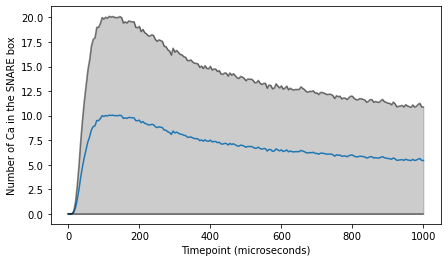

In [27]:
timepts_int = [int(tp) for tp in sampled_timepts]

plt.figure(figsize=(7, 4))
plt.fill_between(timepts_int, np.array(n_ca_all_mean) - np.array(n_ca_all_std), np.array(n_ca_all_mean) + np.array(n_ca_all_std),
                alpha = 0.2, color = 'k')
plt.plot(timepts_int, n_ca_all_mean)
plt.plot(timepts_int, np.array(n_ca_all_mean) + np.array(n_ca_all_std), color = 'k', alpha = 0.5)
plt.plot(timepts_int, np.array(n_ca_all_mean) - np.array(n_ca_all_std), color = 'k', alpha = 0.5)
plt.xlabel("Timepoint (microseconds)")
plt.ylabel("Number of Ca in the SNARE box")
plt.savefig('ca_diff_mcell_output_num.png')
plt.show()

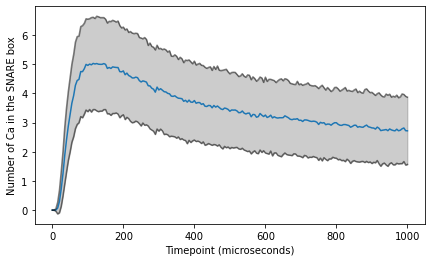

In [35]:
timepts_int = [int(tp) for tp in sampled_timepts]

plt.figure(figsize=(7, 4))
plt.fill_between(timepts_int, np.array(n_ca_all_mean)/2 - np.array(n_ca_all_std)/2, np.array(n_ca_all_mean)/2 + np.array(n_ca_all_std)/2,
                alpha = 0.2, color = 'k')
plt.plot(timepts_int, np.array(n_ca_all_mean)/2)
plt.plot(timepts_int, np.array(n_ca_all_mean)/2 + np.array(n_ca_all_std)/2, color = 'k', alpha = 0.5)
plt.plot(timepts_int, np.array(n_ca_all_mean)/2 - np.array(n_ca_all_std)/2, color = 'k', alpha = 0.5)
plt.xlabel("Timepoint (microseconds)")
plt.ylabel("Number of Ca in the SNARE box")
plt.savefig('ca_diff_mcell_output_num.png')
plt.show()